## Import Dataset

In [ ]:
########## Import dataset from kaggle ##########
import kagglehub
import os
import shutil
import pandas as pd
from glob import glob
# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

final_location = "/content/my_nih_dataset"

# 'path' is the folder KaggleHub created
shutil.move(path, final_location)

# Now everything is at /content/my_nih_dataset
print("New location:", final_location)
print("Files:", os.listdir(final_location))

# Load the CSV file
csv_path = '/content/my_nih_dataset/Data_Entry_2017.csv'
all_xray_df = pd.read_csv(csv_path)

all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content/my_nih_dataset', 'images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Check the structure of the data
print(all_xray_df.head())

100%|██████████| 42.0G/42.0G [31:38<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
New location: /content/my_nih_dataset
Files: ['ARXIV_V5_CHESTXRAY.pdf', 'Data_Entry_2017.csv', 'images_009', 'train_val_list.txt', 'images_001', 'images_004', 'test_list.txt', 'images_007', 'images_002', 'images_012', 'images_006', 'images_003', 'images_008', 'images_010', 'BBox_List_2017.csv', 'images_005', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'images_011', 'README_CHESTXRAY.pdf']
Scans found: 112120 , Total Headers 112120
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  Or

## Data Pipeline Setup

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

img_size = 380
batch_size = 64

all_xray_df = all_xray_df[~all_xray_df['Finding Labels'].str.contains('No Finding')]

all_unique_labels = sorted(set(label for labels in all_xray_df['Finding Labels']
                                  for label in labels.split('|')))
print("Unique labels:", all_unique_labels)

# Create a mapping from label to index.
label_to_index = {label: idx for idx, label in enumerate(all_unique_labels)}

# Function to convert label string to multi-hot encoded vector.
def multi_hot_encode(label_str, label_to_index):
    labels = label_str.split('|')
    vector = np.zeros(len(label_to_index), dtype=np.float32)
    for label in labels:
        vector[label_to_index[label]] = 1.0
    return vector

# Apply multi-hot encoding to the DataFrame.
all_xray_df['multi_hot'] = all_xray_df['Finding Labels'].apply(lambda x: multi_hot_encode(x, label_to_index))


# First, remove rows with missing image paths (if any)
all_xray_df = all_xray_df.dropna(subset=['path'])

#################### Resample with weights ####################
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|'))
                                              if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)
###############################################################

# Split into 70% train, 15% validation, and 15% test.
train_df, temp_df = train_test_split(all_xray_df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train samples:", len(train_df))
print("Validation samples:", len(valid_df))
print("Test samples:", len(test_df))

def load_and_preprocess_image(file_path, label):
    # Read the image from disk.
    image_string = tf.io.read_file(file_path)
    # Decode the PNG image (using 3 channels, adjust if necessary)
    image = tf.image.decode_png(image_string, channels=3)
    # Convert image to float32 in [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to 224x224 (adjust as needed)
    image = tf.image.resize(image, [img_size, img_size])
    return image, label

def create_dataset(df, batch_size=32, shuffle=False):
    # Extract file paths and multi-hot labels.
    paths = df['path'].tolist()
    # Convert list of numpy arrays to a numpy array; this makes it easier for TensorFlow.
    labels = np.stack(df['multi_hot'].values)

    # Create tf.data.Dataset from tensors.
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets.
train_dataset = create_dataset(train_df, batch_size=batch_size, shuffle=True)
valid_dataset = create_dataset(valid_df, batch_size=batch_size, shuffle=False)
test_dataset  = create_dataset(test_df,  batch_size=batch_size, shuffle=False)

Unique labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Train samples: 28000
Validation samples: 6000
Test samples: 6000


<ipython-input-2-7c085984116e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_xray_df['multi_hot'] = all_xray_df['Finding Labels'].apply(lambda x: multi_hot_encode(x, label_to_index))


# Filtering out Bounding Box Images

In [ ]:
import os
import pandas as pd
import shutil
from glob import glob

# Paths
base_dataset_dir = "/content/my_nih_dataset"
bbox_csv_path = os.path.join(base_dataset_dir, "BBox_List_2017.csv")
output_dir = "/content/nih_bbox_images"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load bounding box CSV and get image filenames
bbox_df = pd.read_csv(bbox_csv_path)
bbox_image_names = set(bbox_df['Image Index'].str.strip())  # Ensure no spaces

# Find all images across the 12 folders
all_image_paths = {}
for i in range(1, 13):  # Loop through images_001 to images_012
    folder_path = os.path.join(base_dataset_dir, f"images_{i:03d}", "images")
    for img_path in glob(os.path.join(folder_path, "*.png")):
        img_name = os.path.basename(img_path)
        all_image_paths[img_name] = img_path  # Store full path

# Filter only images with bounding boxes
filtered_images = {name: path for name, path in all_image_paths.items() if name in bbox_image_names}

# Copy filtered images to the output directory
for img_name, img_path in filtered_images.items():
    shutil.copy(img_path, os.path.join(output_dir, img_name))

print(f"Total Bounding Box Images Extracted: {len(filtered_images)}")
print(f"Saved in: {output_dir}")

# Ensure the column exists and is named correctly
print("Columns in bounding box CSV:", bbox_df.columns)

# Print bbox_image_names to check its content
print("bbox_image_names:", bbox_image_names)

Total Bounding Box Images Extracted: 880
Saved in: /content/nih_bbox_images
Columns in bounding box CSV: Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')
bbox_image_names: {'00011136_002.png', '00025368_033.png', '00014022_054.png', '00005532_016.png', '00011925_076.png', '00021818_026.png', '00012045_009.png', '00015831_011.png', '00014731_028.png', '00014706_018.png', '00029431_000.png', '00012094_006.png', '00020986_000.png', '00016837_002.png', '00013106_000.png', '00009256_005.png', '00003333_002.png', '00019150_002.png', '00007728_013.png', '00006948_002.png', '00021374_000.png', '00012123_001.png', '00004968_004.png', '00029647_002.png', '00014706_007.png', '00002980_000.png', '00013922_021.png', '00001933_000.png', '00025747_000.png', '00025662_006.png', '00014177_009.png', '00010767_016.png', '00022021_002.png', '00003528_024.png', '00028924_009.png', '00021409_001.png', '00016191_017.png'

# Converting Bounding Box Coordinates into Segmentation Masks

In [ ]:
import pandas as pd
import cv2
import numpy as np
import os
from tqdm import tqdm

# File paths
metadata_file = "/content/my_nih_dataset/BBox_List_2017.csv"
images_folder = "nih_bbox_images/"         # Folder with 880 X-ray images that have bounding boxes
output_masks_folder = "bbox_masks/"        # Folder to save generated masks

# Create output folder if it doesn't exist
os.makedirs(output_masks_folder, exist_ok=True)

# Load and clean bounding box CSV
df = pd.read_csv(metadata_file)

# Fix column names
df.columns = ['Image Index', 'Finding Label', 'Bbox_x', 'Bbox_y', 'Bbox_w', 'Bbox_h', 'Unused1', 'Unused2', 'Unused3']

# OPTIONAL: Filter only the images already in nih_bbox_images folder
available_images = set(os.listdir(images_folder))
df = df[df['Image Index'].isin(available_images)]

# Loop through each row and create mask
for idx, row in tqdm(df.iterrows(), total=len(df)):
    image_name = row['Image Index']
    x, y, w, h = row['Bbox_x'], row['Bbox_y'], row['Bbox_w'], row['Bbox_h']

    image_path = os.path.join(images_folder, image_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        continue  # Skip if image couldn't be read

    # Create black mask of same size as image
    mask = np.zeros_like(img, dtype=np.uint8)

    # Draw white bounding box
    x, y, w, h = int(x), int(y), int(w), int(h)
    mask[y:y+h, x:x+w] = 255

    # Save mask
    mask_path = os.path.join(output_masks_folder, image_name)
    cv2.imwrite(mask_path, mask)


100%|██████████| 984/984 [00:15<00:00, 63.46it/s]


# Data Preprocessing with tf.data Data Pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Updated paths
images_folder = "nih_bbox_images/"
masks_folder = "bbox_masks/"

# Load image filenames (only ones that exist in both folders)
image_filenames = sorted(os.listdir(images_folder))
mask_filenames = sorted(os.listdir(masks_folder))

# Ensure only image-mask pairs are used (sanity check)
common_filenames = list(set(image_filenames).intersection(set(mask_filenames)))
common_filenames.sort()  # sort for consistent pairing

# Function to load and preprocess images/masks
def load_data(image_path, mask_path, img_size=(256, 256)):
    img = load_img(image_path, target_size=img_size, color_mode="grayscale")
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

    img = img_to_array(img) / 255.0
    mask = img_to_array(mask) / 255.0

    return img, mask

# Load all image-mask pairs
images, masks = [], []
for fname in common_filenames:
    img_path = os.path.join(images_folder, fname)
    mask_path = os.path.join(masks_folder, fname)

    img, mask = load_data(img_path, mask_path)
    images.append(img)
    masks.append(mask)

# Convert to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Train/val/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# TF Dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

print("Number of training images:", len(X_train))
print("Number of validation images:", len(X_val))
print("Number of test images:", len(X_test))


Number of training images: 616
Number of validation images: 132
Number of test images: 132


# U-Net Model Implementation

In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(b)
    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u2)
    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c4 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c4)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c4)

    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,107,585 (4.23 MB)

 Trainable params: 1,107,585 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

# ResUNet (using ResNet50V2) with Image Segmentation

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, Input

def build_resunet_with_resnet50(input_shape=(256, 256, 3)):
    # Load pre-trained ResNet50V2 as encoder
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the backbone for now

    # Encoder skip connections
    c1 = base_model.get_layer("conv1_conv").output      # 128x128
    c2 = base_model.get_layer("conv2_block3_out").output # 64x64
    c3 = base_model.get_layer("conv3_block4_out").output # 32x32
    c4 = base_model.get_layer("conv4_block6_out").output # 16x16
    b = base_model.get_layer("conv5_block3_out").output  # 8x8 bottleneck

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c4])
    u1 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(u1)

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c3])
    u2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(u2)

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Concatenate()([u3, c2])
    u3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(u3)

    u4 = layers.UpSampling2D((2, 2))(u3)
    u4 = layers.Concatenate()([u4, c1])
    u4 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(u4)

    u5 = layers.UpSampling2D((2, 2))(u4)
    u5 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(u5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u5)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Build model
resunet_tl = build_resunet_with_resnet50()

# Compile
resunet_tl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resunet_tl.summary()


# U-Net Model Training

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 318ms/step - accuracy: 0.8385 - loss: 0.4556 - val_accuracy: 0.9278 - val_loss: 0.2556
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9198 - loss: 0.2693 - val_accuracy: 0.9278 - val_loss: 0.2698
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9267 - loss: 0.2478 - val_accuracy: 0.9278 - val_loss: 0.2456
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9231 - loss: 0.2486 - val_accuracy: 0.9278 - val_loss: 0.2458
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9226 - loss: 0.2477 - val_accuracy: 0.9278 - val_loss: 0.2362
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9245 - loss: 0.2410 - val_accuracy: 0.9278 - val_loss: 0.2369
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9235 - loss: 0.2441 - val_accuracy: 0.9278 - val_loss: 0.2341
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9248 - loss: 0.2398 - val_accuracy: 0.9278 -

# Testing and Metrics

In [ ]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    # Cast y_pred_f to float32 before multiplication
    y_pred_f = K.cast(K.flatten(y_pred > 0.5), K.floatx())
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    # Cast y_pred_f to float32 before multiplication
    y_pred_f = K.cast(K.flatten(y_pred > 0.5), K.floatx())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric, dice_coefficient])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_unet_model.h5', monitor='val_loss', save_best_only=True)
]


In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30,
                    callbacks=callbacks)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9263 - dice_coefficient: 1.3596e-11 - iou_metric: 1.3596e-11 - loss: 0.2343

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9262 - dice_coefficient: 1.3609e-11 - iou_metric: 1.3609e-11 - loss: 0.2342 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2298
Epoch 2/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9185 - dice_coefficient: 1.2194e-11 - iou_metric: 1.2194e-11 - loss: 0.2441

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9188 - dice_coefficient: 1.2275e-11 - iou_metric: 1.2275e-11 - loss: 0.2434 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2263
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9250 - dice_coefficient: 1.3726e-11 - iou_metric: 1.3726e-11 - loss: 0.2302 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2321
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9219 - dice_coefficient: 1.3166e-11 - iou_metric: 1.3166e-11 - loss: 0.2417 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2308
Epoch 5/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9190 - dice_coefficient: 1.2619e-11 - iou_metric: 1.2619e-11 - loss: 0.2434

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9193 - dice_coefficient: 1.2692e-11 - iou_metric: 1.2692e-11 - loss: 0.2427 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2256
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9281 - dice_coefficient: 1.3813e-11 - iou_metric: 1.3813e-11 - loss: 0.2196 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2265
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9211 - dice_coefficient: 1.3157e-11 - iou_metric: 1.3157e-11 - loss: 0.2358 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2261
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9248 - dice_coefficient: 1.3461e-11 - iou_metric: 1.3461e-11 - loss: 0.2300 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2262
Epoch 9/30
39/39 ━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9241 - dice_coefficient: 1.3146e-11 - iou_metric: 1.3146e-11 - loss: 0.2255 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2231
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9276 - dice_coefficient: 1.3955e-11 - iou_metric: 1.3955e-11 - loss: 0.2207 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2257
Epoch 12/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9230 - dice_coefficient: 1.3320e-11 - iou_metric: 1.3320e-11 - loss: 0.2315

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9231 - dice_coefficient: 1.3337e-11 - iou_metric: 1.3337e-11 - loss: 0.2311 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2226
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9236 - dice_coefficient: 1.3165e-11 - iou_metric: 1.3165e-11 - loss: 0.2321 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2264
Epoch 14/30
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9261 - dice_coefficient: 1.3538e-11 - iou_metric: 1.3538e-11 - loss: 0.2229

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9260 - dice_coefficient: 1.3555e-11 - iou_metric: 1.3555e-11 - loss: 0.2230 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2215
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9241 - dice_coefficient: 1.3661e-11 - iou_metric: 1.3661e-11 - loss: 0.2240 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2276
Epoch 16/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9295 - dice_coefficient: 1.4494e-11 - iou_metric: 1.4494e-11 - loss: 0.2190 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2232
Epoch 17/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9234 - dice_coefficient: 1.3024e-11 - iou_metric: 1.3024e-11 - loss: 0.2239 - val_accuracy: 0.9278 - val_dice_coefficient: 2.0962e-11 - val_iou_metric: 2.0962e-11 - val_loss: 0.2266
Epoch 18/30
39/39 ━━

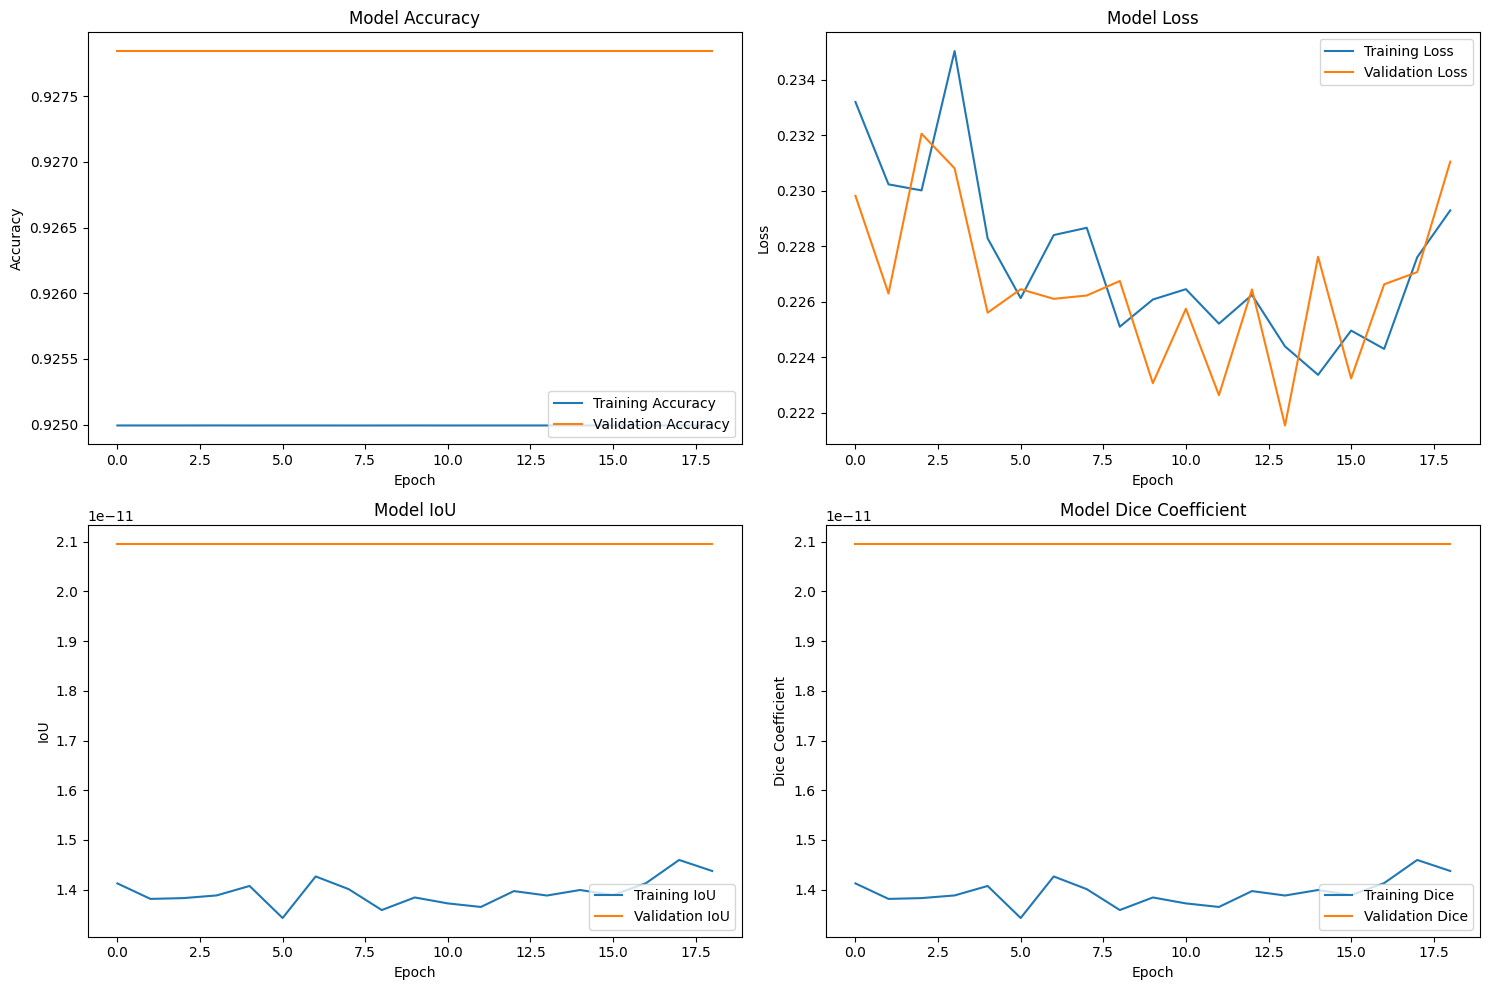

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots the training and validation metrics in a 2x2 grid."""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Create a 2x2 grid of subplots

    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(loc='lower right')

    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(loc='upper right')

    # Plot IoU metric
    axes[1, 0].plot(history.history['iou_metric'], label='Training IoU')
    axes[1, 0].plot(history.history['val_iou_metric'], label='Validation IoU')
    axes[1, 0].set_title('Model IoU')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(loc='lower right')

    # Plot Dice coefficient
    axes[1, 1].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 1].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 1].set_title('Model Dice Coefficient')
    axes[1, 1].set_ylabel('Dice Coefficient')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(loc='lower right')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)

# Visualizations of Model Predictions

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_images=5):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[i].numpy().squeeze(), cmap='gray')
            ax[0].set_title('Input Image')
            ax[1].imshow(masks[i].numpy().squeeze(), cmap='gray')
            ax[1].set_title('True Mask')
            ax[2].imshow(preds[i].squeeze(), cmap='gray')
            ax[2].set_title('Predicted Mask')
            plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


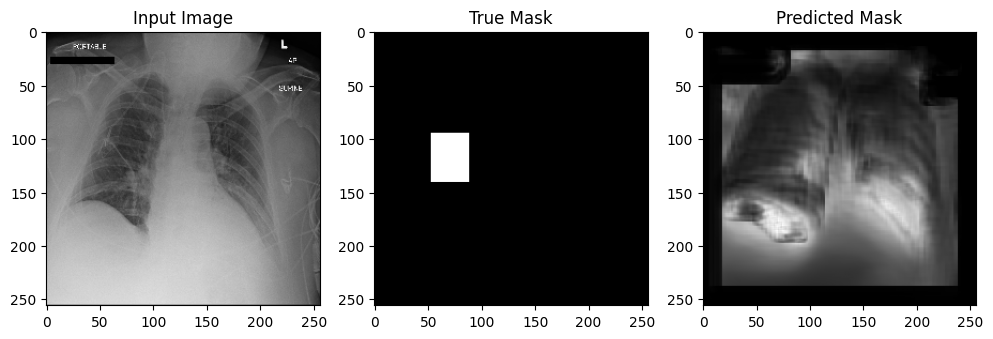

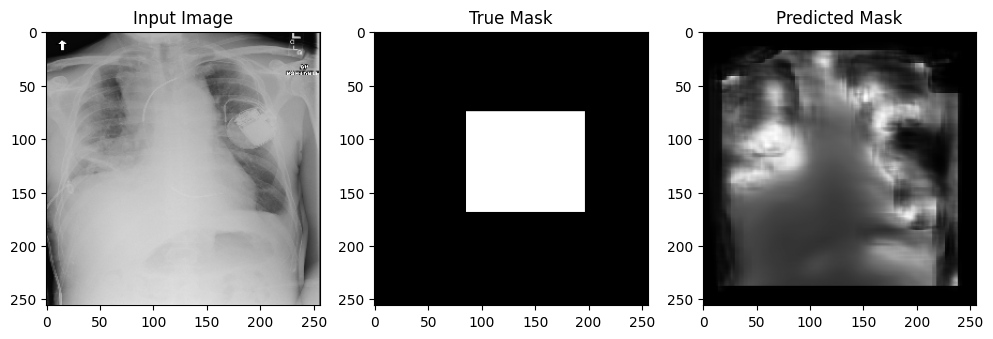

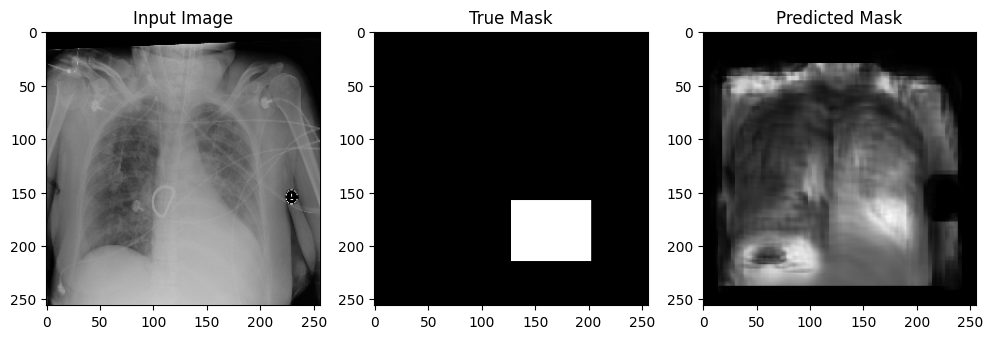

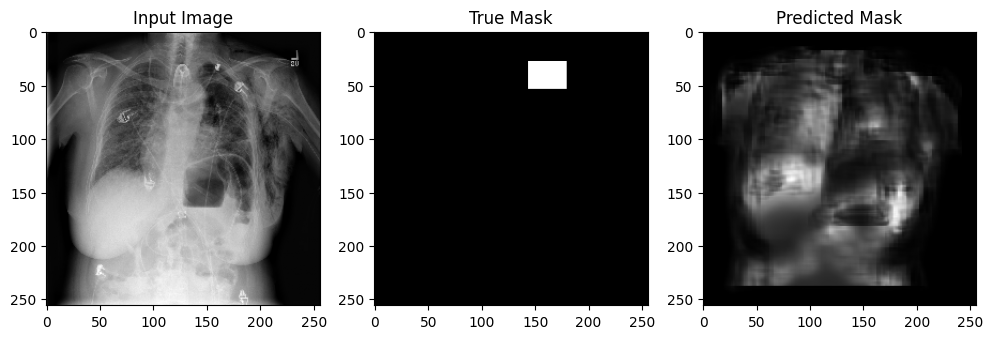

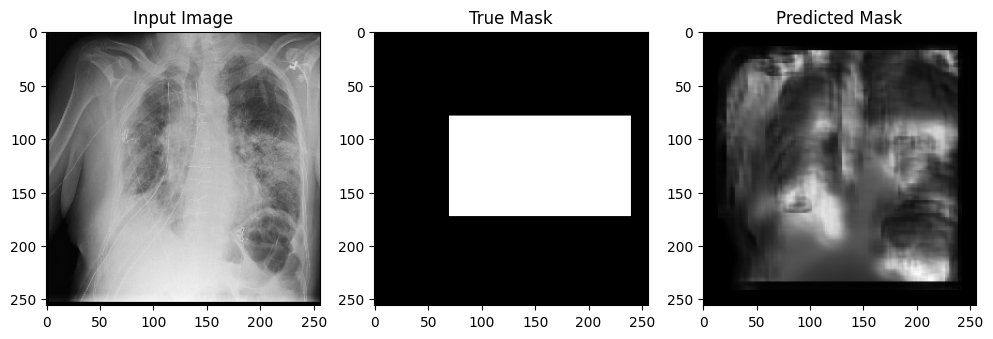

In [ ]:
visualize_predictions(model, test_dataset)

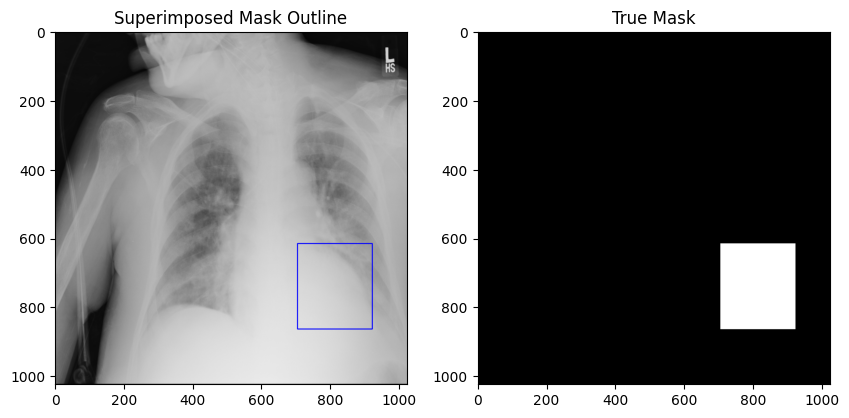

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def superimpose_mask_outline(image_path, mask_path, alpha=0.5, color=(0, 0, 255)):  # Red color by default
    """
    Superimposes a mask outline on an image.

    Args:
        image_path: Path to the input image file.
        mask_path: Path to the mask image file.
        alpha: The transparency level of the mask (0.0-1.0).
        color: The color to use for the mask outline (RGB tuple).

    Returns:
        The image with the superimposed mask outline.
    """

    # Load the image and mask using cv2.imread
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if images were loaded successfully
    if image is None or mask is None:
        print(f"Error: Could not load image or mask from paths: {image_path}, {mask_path}")
        return None

    # Convert image and mask to RGB if they are grayscale
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if len(mask.shape) == 2:  # Grayscale mask
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Ensure image and mask have the same data type
    image = image.astype(np.uint8)
    mask = mask.astype(np.uint8)

    # Find contours in the mask to get the outline
    contours, _ = cv2.findContours(mask[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours (outline) on the image
    cv2.drawContours(image, contours, -1, color, 2)  # 2 is the thickness of the line

    return image, mask[:, :, 0]  # Return image with outline and the original mask


# Example usage:
image_path = "/content/nih_bbox_images/00000193_019.png"
mask_path = "/content/bbox_masks/00000193_019.png"

superimposed_image, original_mask = superimpose_mask_outline(image_path, mask_path)

if superimposed_image is not None:
    # Display the superimposed image and the true mask side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(superimposed_image)
    axes[0].set_title('Superimposed Mask Outline')
    axes[1].imshow(original_mask, cmap='gray')
    axes[1].set_title('True Mask')
    plt.show()

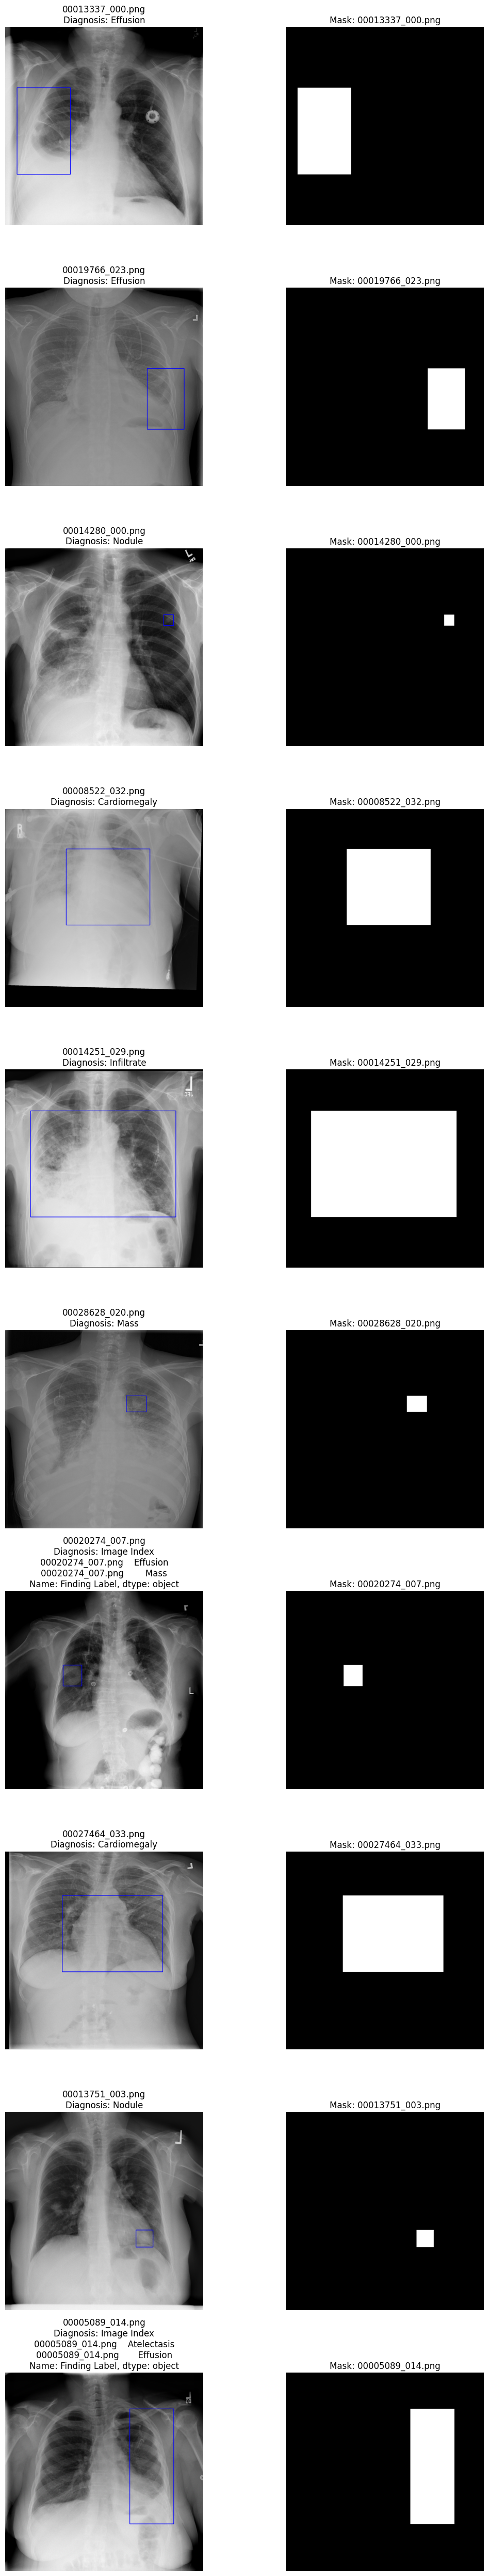

In [ ]:
import os
import matplotlib.pyplot as plt
import random
import pandas as pd

# Load the bounding box CSV
bbox_csv_path = "/content/my_nih_dataset/BBox_List_2017.csv"  # Change this path if needed
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df.set_index("Image Index", inplace=True)  # Use image filenames as index for fast lookup

def display_multiple_superimposed_images(images_folder, masks_folder, bbox_df, num_images=5):
    """
    Displays multiple images with superimposed mask outlines and diagnosis labels.

    Args:
        images_folder: Path to the folder containing the images.
        masks_folder: Path to the folder containing the masks.
        bbox_df: Pandas DataFrame with image filenames as index and diagnoses.
        num_images: The number of images to display.
    """
    image_filenames = os.listdir(images_folder)
    random.shuffle(image_filenames)
    selected_filenames = image_filenames[:num_images]

    fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))  # 2 columns: superimposed + mask

    for i, filename in enumerate(selected_filenames):
        image_path = os.path.join(images_folder, filename)
        mask_path = os.path.join(masks_folder, filename)

        superimposed_image, original_mask = superimpose_mask_outline(image_path, mask_path)

        if superimposed_image is not None:
            # Get diagnosis from CSV (default to "Unknown" if not found)
            diagnosis = "Unknown"
            if filename in bbox_df.index:
                diagnosis = bbox_df.loc[filename, "Finding Label"] if "Finding Label" in bbox_df.columns else bbox_df.loc[filename, "Finding Labels"]

            # Display the superimposed image with diagnosis
            axes[i, 0].imshow(superimposed_image)
            axes[i, 0].set_title(f'{filename}\nDiagnosis: {diagnosis}')
            axes[i, 0].axis('off')

            # Display the original mask
            axes[i, 1].imshow(original_mask, cmap='gray')
            axes[i, 1].set_title(f'Mask: {filename}')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
images_folder = "/content/nih_bbox_images/"
masks_folder = "/content/bbox_masks/"
display_multiple_superimposed_images(images_folder, masks_folder, bbox_df, num_images=10)


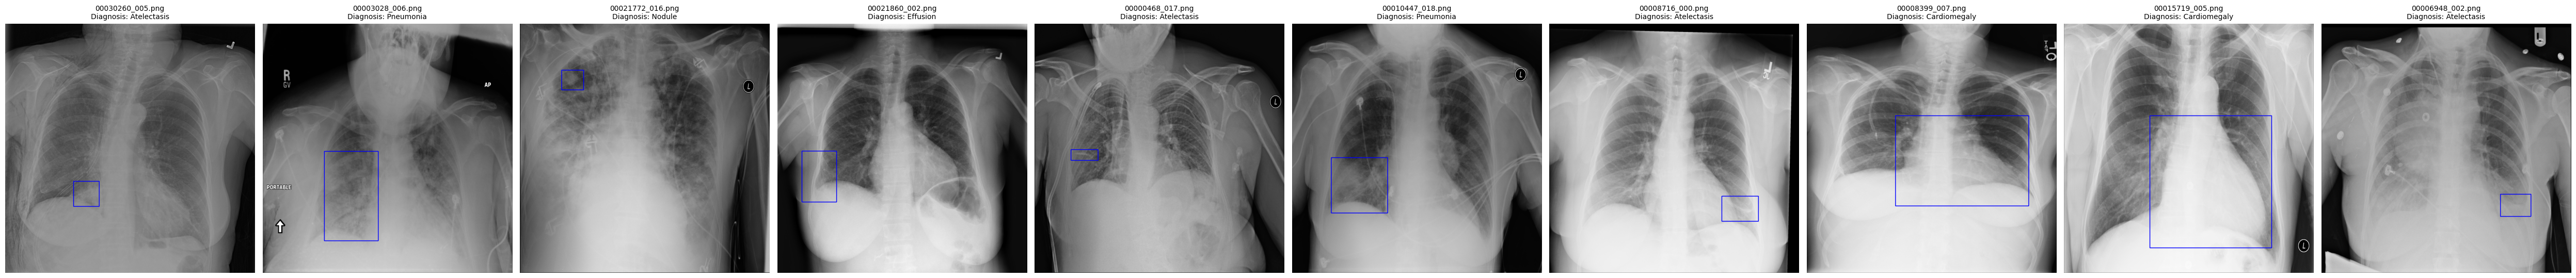

In [ ]:
import os
import matplotlib.pyplot as plt
import random
import pandas as pd

# Load the bounding box CSV
bbox_csv_path = "/content/my_nih_dataset/BBox_List_2017.csv"
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df.set_index("Image Index", inplace=True)

def display_superimposed_images_with_diagnosis(images_folder, masks_folder, bbox_df, num_images=5):
    """
    Displays images with superimposed mask outlines and diagnosis labels (no separate mask image).

    Args:
        images_folder: Path to the folder containing the images.
        masks_folder: Path to the folder containing the masks.
        bbox_df: Pandas DataFrame with image filenames as index and diagnoses.
        num_images: The number of images to display.
    """
    image_filenames = os.listdir(images_folder)
    random.shuffle(image_filenames)
    selected_filenames = image_filenames[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 6))

    if num_images == 1:
        axes = [axes]  # Make iterable if only one subplot

    for i, filename in enumerate(selected_filenames):
        image_path = os.path.join(images_folder, filename)
        mask_path = os.path.join(masks_folder, filename)

        superimposed_image, _ = superimpose_mask_outline(image_path, mask_path)

        if superimposed_image is not None:
            diagnosis = "Unknown"
            if filename in bbox_df.index:
                diagnosis = bbox_df.loc[filename, "Finding Label"] if "Finding Label" in bbox_df.columns else bbox_df.loc[filename, "Finding Labels"]

            axes[i].imshow(superimposed_image)
            axes[i].set_title(f'{filename}\nDiagnosis: {diagnosis}', fontsize=10)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
images_folder = "/content/nih_bbox_images/"
masks_folder = "/content/bbox_masks/"
display_superimposed_images_with_diagnosis(images_folder, masks_folder, bbox_df, num_images=10)
